In [114]:
from fish_helpers import *
from analysis_scripts.classify import *
cstk_path = '/hybedata/Images/Robert/TBI_v2/sham_m3_slide4_2019Nov04/codestacks_v1/'


In [4]:
pos,poses = find_subset(cstk_path,1,18)
pos = pos[0]
print(pos)

Pos270


In [6]:
hdata = HybeData(os.path.join(cstk_path,pos))
z = 11
cstk = hdata.load_data(pos,z,'cstk')
cimg = hdata.load_data(pos,z,'cimg')
nf = hdata.load_data(pos,z,'nf')

In [7]:
norm_vector = nf

In [58]:
cstk = cstk.copy()
cstk = cstk.astype('float32')
cstk = np.nan_to_num(cstk)
# Prevent possible underflow/divide_zero errors
np.place(cstk, cstk<=0, 0.01)
# Normalize for intensity difference between codebits
normstk = np.divide(cstk, norm_vector)
# Fill class img one column at a time
class_img = np.empty((cstk.shape[0], cstk.shape[1]), dtype=np.int16)
distance_img = np.empty((cstk.shape[0], cstk.shape[1]), dtype=np.float64)

In [11]:
mask = class_img>-2

In [14]:
cword_config = 'seqfish_config_tbi_v4'
seqfish_config = importlib.import_module(cword_config)
try:
    genes = seqfish_config.gids+seqfish_config.bids
except:
    genes = seqfish_config.gids
bitmap = seqfish_config.bitmap
normalized_gene_vectors = seqfish_config.norm_gene_codeword_vectors
normalized_all_gene_vectors = seqfish_config.norm_all_codeword_vectors
codeword_vectors = normalized_all_gene_vectors

In [16]:
csphere_radius = 0.5176

In [17]:
i = 0
v = normstk[i, :, :]  # v is shape (2048, n_bits)
# l2 norm note codeword_vectors should be prenormalized
v = normalize(v, norm='l2')
v[mask[i,:]==False]=False
# Distance from unit vector of codewords and candidate pixel codebits
d = distance_matrix(codeword_vectors, v)
# Check if distance to closest unit codevector is less than csphere thresh
dmin = np.argmin(d, axis=0)
dis = np.min(d,axis=0)
dvs = np.array([i if d[i, idx]<csphere_radius else -1 for idx, i in enumerate(dmin)])
temp_cvs = codeword_vectors[dvs]
temp_cvs[temp_cvs>0] = 1
n_bits = np.sum(temp_cvs[0])
ssums = np.sum(cstk[i,:,:]*temp_cvs, axis=1)

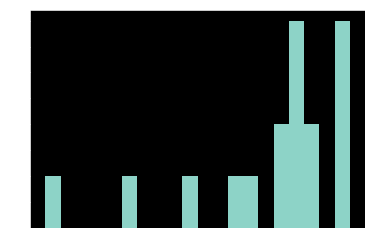

In [37]:
plt.hist(dis[dvs>-1],bins=20)
plt.show()

In [62]:
for i in range(cstk.shape[0]):
    v = normstk[i, :, :]  # v is shape (2048, n_bits)
    # l2 norm note codeword_vectors should be prenormalized
    v = normalize(v, norm='l2')
    v[mask[i,:]==False]=False
    # Distance from unit vector of codewords and candidate pixel codebits
    d = distance_matrix(codeword_vectors, v)
    # Check if distance to closest unit codevector is less than csphere thresh
    dmin = np.argmin(d, axis=0)
    dis = np.min(d,axis=0)
    dvs = np.array([i if d[i, idx]<csphere_radius else -1 for idx, i in enumerate(dmin)])
    class_img[i, :] = dvs
    distance_img[i,:] = dis

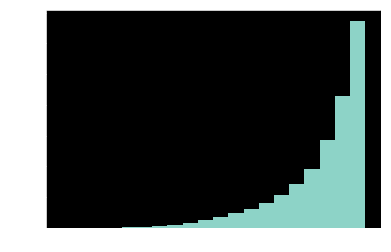

In [63]:
plt.hist(distance_img[class_img>-1].ravel(),bins=20)
plt.show()

In [65]:
cvectors = codeword_vectors

In [79]:
nf_dict = {}
for bit in range(cvectors.shape[1]):
    nf_dict[bit] = {}
    for gene in genes:
        nf_dict[bit][gene]=[]
label2d = label((class_img+1).astype('uint16'), neighbors=8)
properties = regionprops(label2d, (class_img+1).astype('uint16'))
areas = []
nclasses = []
multiclass_sets = 0
gene_call_rows = []
below_threshold_rows = []
pix_thresh=1
ave_thresh=0
spot_sum_thresh=0
for prop in properties:
    coords = prop.coords
    centroid = prop.centroid
    classes = list(set(prop.intensity_image.flatten())-set([0]))
    if len(classes)==0:
        print('Label with no classes.', end='')
        pdb.set_trace()
        continue
    elif not len(classes)==1:
        pdb.set_trace()
        multiclass_sets+=1
        continue
    else:
        nclasses.append(len(classes))
        areas.append(prop.area)
    codeword_idx = classes[0]-1
    gene = genes[codeword_idx]
    bits = np.where(cvectors[codeword_idx]>0)[0]
    spot_pixel_values = []
    spot_pixel_means = []
    spot_distance = np.mean(distance_img[coords[:,0], coords[:,1]])
    # Calculating the mean pixel intensities for each positive bit for a single spot
    spot_nf = np.zeros(cvectors.shape[1])
    for b in bits:
        spot_bit_intensities = cstk[coords[:,0], coords[:,1], b]
        spot_nf[b] = np.mean(spot_bit_intensities)
        spot_pixel_values.append(spot_bit_intensities)
    spot_sum = np.sum(spot_pixel_values)
    spot_mean = np.mean(spot_pixel_values)
    # If the spot is above spot_sum_thresh then add it to the gene spot list
    # the hope is to filter out background here
    if (len(coords)>pix_thresh) and (spot_mean>ave_thresh) and (spot_sum>spot_sum_thresh):
        for b in bits:
            nf_dict[b][gene].append(spot_nf[b])
    gene_call_rows.append([genes[codeword_idx], spot_sum, centroid,
                    spot_mean, len(coords), codeword_idx,spot_distance])
df = pd.DataFrame(gene_call_rows, columns=['gene', 'ssum', 'centroid', 'ave', 'npixels', 'cword_idx','distance'])


In [80]:
df

,gene,ssum,centroid,ave,npixels,cword_idx,distance
0,Gad1,29.0,"(0.0, 70.0)",7.250000,1,53,0.511191
1,Igf1,100.0,"(0.5, 178.0)",12.500000,2,71,0.450870
2,Ppp1r9a,21.0,"(0.0, 312.0)",5.250000,1,118,0.509297
3,Bptf,574.0,"(0.4, 384.8)",28.700001,5,11,0.434888
4,Cxcl12,32.0,"(0.0, 557.0)",8.000000,1,32,0.487722
...,...,...,...,...,...,...,...
16107,Gfap,304.0,"(2047.0, 87.0)",25.333334,3,55,0.464276
16108,Ctdsp2,45.0,"(2047.0, 491.0)",11.250000,1,29,0.514979
16109,Fam216b,133.0,"(2047.0, 603.5)",16.625000,2,43,0.458908
16110,Ncan,105.0,"(2047.0, 1189.0)",26.250000,1,99,0.494940


In [117]:
hip = pd.read_csv('/bigstore/binfo/mouse/Hippocampus/GSE74985_genes.fpkm_tracking',sep='\t')
hip_fpkm = pd.DataFrame(index = hip.gene_short_name)
for column in hip.columns:
    if 'FPKM' in column:
        hip_fpkm[column] = list(hip[column])
hip_fpkm['average'] = np.average(hip_fpkm,axis=1)
hip_fpkm

,dg_d_FPKM,dg_v_FPKM,ca4_FPKM,ca3_d_FPKM,ca3_v_FPKM,ca2_FPKM,ca1_d_FPKM,ca1_v_FPKM,average
gene_short_name,,,,,,,,,
Gnai3,8.131250,11.763400,10.673600,18.301500,10.505900,10.71920,7.859310,9.818570,10.971591
Pbsn,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
Cdc45,0.000000,2.597860,1.023760,0.621743,1.248480,2.20752,0.201932,1.372640,1.159242
H19,0.000000,0.000000,0.008192,0.178003,0.000000,0.00000,0.000000,0.000000,0.023274
Scml2,0.011255,0.303125,0.039321,0.031681,0.185555,0.69732,0.011220,0.088365,0.170980
...,...,...,...,...,...,...,...,...,...
-,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
-,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
-,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


158


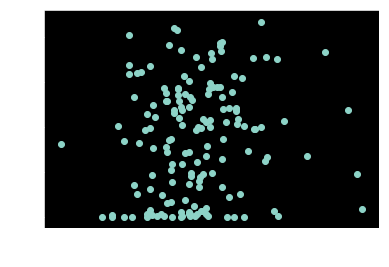

SpearmanrResult(correlation=0.14228636851853027, pvalue=0.07452192756800709)

In [84]:
hip_fpkm.index = [i.capitalize() for i in hip_fpkm.index]
shared_genes = [i for i in df.gene.unique() if i in hip_fpkm.index]
shared_genes = [i for i in shared_genes if not 'Malat' in i]
print(len(shared_genes))
c = []
s = []
for gn,cc in Counter(df.gene).items():
    if gn in shared_genes:
        c.append(cc)
        ts = hip_fpkm['average'].loc[gn]
        if isinstance(ts,float):
            s.append(ts)
        else:
            s.append(ts.iloc[0])
plt.scatter(np.log10(np.array(c)+1),np.log10(np.array(s)+1))
plt.xlabel('sham_m3_slide4_2019Nov04 counts')
plt.ylabel('bulk hippocampus rnaseq')
plt.show()
spearmanr(c,s)

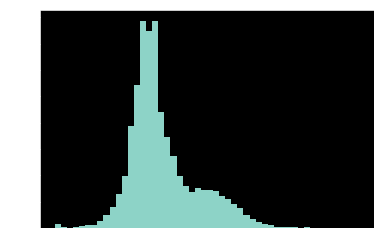

In [85]:
plt.hist(np.log10(df.ave),bins=50)
plt.show()

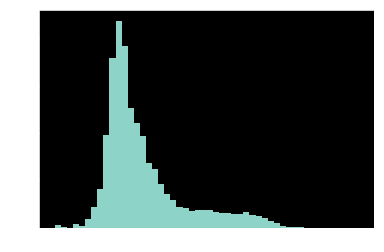

In [86]:
plt.hist(np.log10(df.ssum),bins=50)
plt.show()

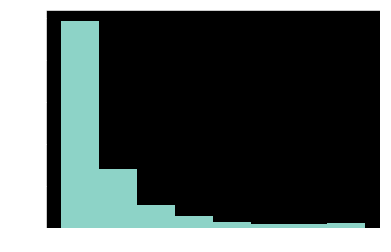

In [87]:
plt.hist(df.npixels,bins=[1,2,3,4,5,6,7,8,9])
plt.show()

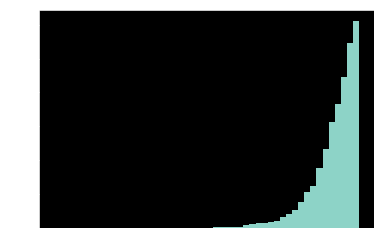

In [89]:
plt.hist(df.distance,bins=50)
plt.show()

0.14206802383316783


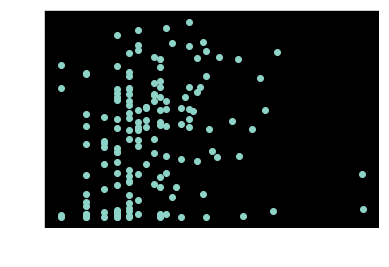

SpearmanrResult(correlation=0.26175733755113484, pvalue=0.000893003300395477)

In [98]:
filtered_df = df[(df.distance<0.45)]
print(len(filtered_df)/len(df))
c = []
s = []
for gn,cc in Counter(filtered_df.gene).items():
    if gn in shared_genes:
        c.append(cc)
        ts = hip_fpkm['average'].loc[gn]
        if isinstance(ts,float):
            s.append(ts)
        else:
            s.append(ts.iloc[0])
plt.scatter(np.log10(np.array(c)+1),np.log10(np.array(s)+1))
plt.xlabel('sham_m3_slide4_2019Nov04 counts')
plt.ylabel('bulk hippocampus rnaseq')
plt.show()
spearmanr(c,s)

0.20885054617676266


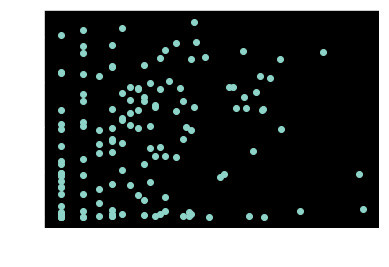

SpearmanrResult(correlation=0.22155175233655794, pvalue=0.008763973090842756)

In [112]:
filtered_df = df[(df.ave>10**1.25)]
print(len(filtered_df)/len(df))
c = []
s = []
for gn,cc in Counter(filtered_df.gene).items():
    if gn in shared_genes:
        c.append(cc)
        ts = hip_fpkm['average'].loc[gn]
        if isinstance(ts,float):
            s.append(ts)
        else:
            s.append(ts.iloc[0])
plt.scatter(np.log10(np.array(c)+1),np.log10(np.array(s)+1))
plt.xlabel('sham_m3_slide4_2019Nov04 counts')
plt.ylabel('bulk hippocampus rnaseq')
plt.show()
spearmanr(c,s)

995


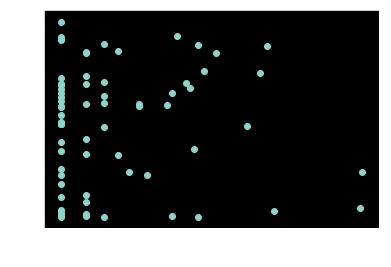

SpearmanrResult(correlation=0.0731746236415351, pvalue=0.5412920899920385)

In [113]:
filtered_df = df[(df.npixels>1)&(df.distance<0.45)&(df.ave>10**1.25)]
print(len(filtered_df))
c = []
s = []
for gn,cc in Counter(filtered_df.gene).items():
    if gn in shared_genes:
        c.append(cc)
        ts = hip_fpkm['average'].loc[gn]
        if isinstance(ts,float):
            s.append(ts)
        else:
            s.append(ts.iloc[0])
plt.scatter(np.log10(np.array(c)+1),np.log10(np.array(s)+1))
plt.xlabel('sham_m3_slide4_2019Nov04 counts')
plt.ylabel('bulk hippocampus rnaseq')
plt.show()
spearmanr(c,s)

In [104]:
xy = np.stack(df.centroid)
df['x'] = list(xy[:,1])
df['y'] = list(xy[:,0])
filtered_df = df[(df.npixels>1)&(df.distance<0.45)]

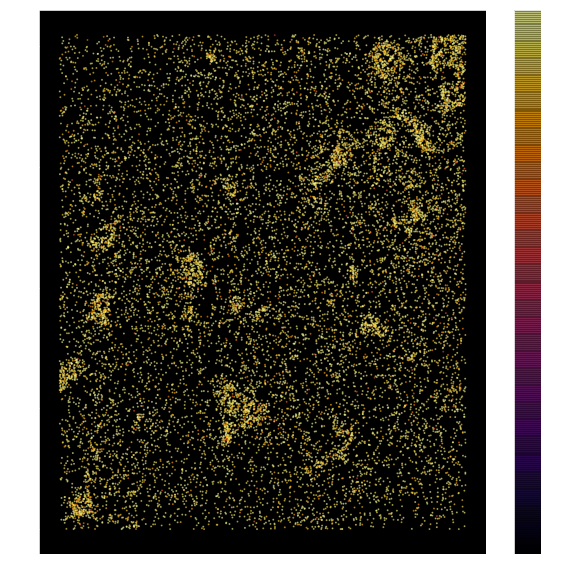

In [108]:
plt.figure(figsize=[10,10])
plt.scatter(df.x,df.y,s=1,alpha=0.5,c=df.distance,cmap='inferno')
plt.colorbar()
plt.show()

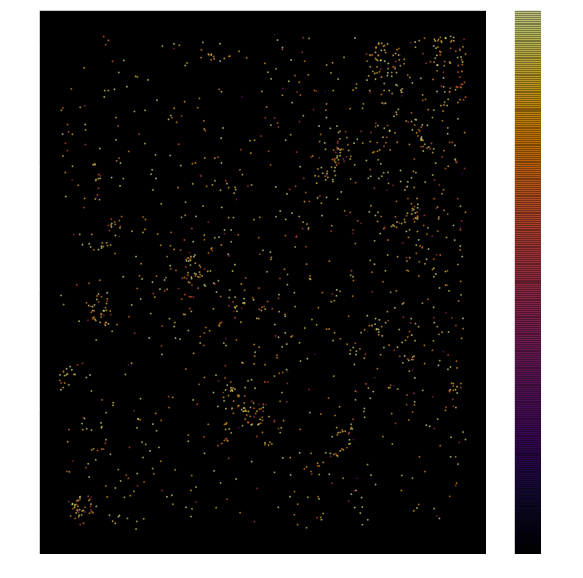

In [109]:
plt.figure(figsize=[10,10])
plt.scatter(filtered_df.x,filtered_df.y,s=1,alpha=0.5,c=filtered_df.distance,cmap='inferno')
plt.colorbar()
plt.show()

In [ ]:
def parse_classification_image(class_img, cstk, cvectors, genes, zindex, distance_img, pix_thresh=1, ave_thresh=0, spot_sum_thresh=0 ):
    # Calculating nf during parse for better control
    # Set up a dictionary where each key is a bit
    # Each bit will have a dictionary of spots
    # Each Spot dict will have the mean spot intensities for all spots 
    #     classified above spot_sum_thresh
    nf_dict = {}
    for bit in range(cvectors.shape[1]):
        nf_dict[bit] = {}
        for gene in genes:
            nf_dict[bit][gene]=[]
    label2d = label((class_img+1).astype('uint16'), neighbors=8)
    properties = regionprops(label2d, (class_img+1).astype('uint16'))
    areas = []
    nclasses = []
    multiclass_sets = 0
    gene_call_rows = []
    below_threshold_rows = []
    for prop in properties:
        coords = prop.coords
        centroid = prop.centroid
        classes = list(set(prop.intensity_image.flatten())-set([0]))
        if len(classes)==0:
            print('Label with no classes.', end='')
            pdb.set_trace()
            continue
        elif not len(classes)==1:
            pdb.set_trace()
            multiclass_sets+=1
            continue
        else:
            nclasses.append(len(classes))
            areas.append(prop.area)
        codeword_idx = classes[0]-1
        gene = genes[codeword_idx]
        bits = np.where(cvectors[codeword_idx]>0)[0]
        spot_pixel_values = []
        spot_pixel_means = []
        spot_sums = 0
        # Calculating the mean pixel intensities for each positive bit for a single spot
        spot_nf = np.zeros(cvectors.shape[1])
        for b in bits:
            spot_bit_intensities = cstk[coords[:,0], coords[:,1], b]
            spot_nf[b] = np.mean(spot_bit_intensities)
            spot_pixel_values.append(spot_bit_intensities)
        spot_sum = np.sum(spot_pixel_values)
        spot_mean = np.mean(spot_pixel_values)
        # If the spot is above spot_sum_thresh then add it to the gene spot list
        # the hope is to filter out background here
        if (len(coords)>pix_thresh) and (spot_mean>ave_thresh) and (spot_sum>spot_sum_thresh):
            for b in bits:
                nf_dict[b][gene].append(spot_nf[b])
        gene_call_rows.append([genes[codeword_idx], spot_sum, centroid,
                        np.mean(spot_mean), len(coords), codeword_idx])
    df = pd.DataFrame(gene_call_rows, columns=['gene', 'ssum', 'centroid', 'ave', 'npixels', 'cword_idx'])
    # Generate an empty nf to populate
    nf = np.zeros(cvectors.shape[1])
    for b in nf_dict.keys():
        bit_nf = []
        # mean the spot intensities for a gene so that all genes have the same weight
        # This is to prevent highly expressed false spots from skewing nf
        for gene,gene_bit_spot_intensities in nf_dict[b].items():
            if len(gene_bit_spot_intensities)>0:
                bit_nf.append(np.mean(gene_bit_spot_intensities))
        nf[b] = np.mean(bit_nf)
    return df,nf

In [142]:
spotcalls = pickle.load(open(os.path.join(cstk_path,'spotcalls_iteration_1.pkl'),'rb'))

In [143]:
xy = np.stack(spotcalls.centroid)
spotcalls['x'] = list(xy[:,1])
spotcalls['y'] = list(xy[:,0])

158


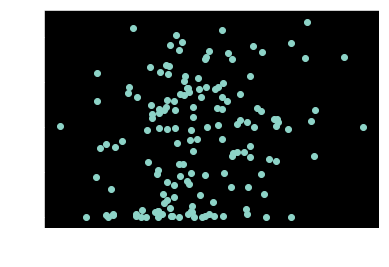

SpearmanrResult(correlation=0.18081149391680465, pvalue=0.022996624735496952)

In [144]:
hip_fpkm.index = [i.capitalize() for i in hip_fpkm.index]
shared_genes = [i for i in spotcalls.gene.unique() if i in hip_fpkm.index]
shared_genes = [i for i in shared_genes if not 'Malat' in i]
print(len(shared_genes))
c = []
s = []
for gn,cc in Counter(spotcalls.gene).items():
    if gn in shared_genes:
        c.append(cc)
        ts = hip_fpkm['average'].loc[gn]
        if isinstance(ts,float):
            s.append(ts)
        else:
            s.append(ts.iloc[0])
plt.scatter(np.log10(np.array(c)+1),np.log10(np.array(s)+1))
plt.xlabel('sham_m3_slide4_2019Nov04 counts')
plt.ylabel('bulk hippocampus rnaseq')
plt.show()
spearmanr(c,s)

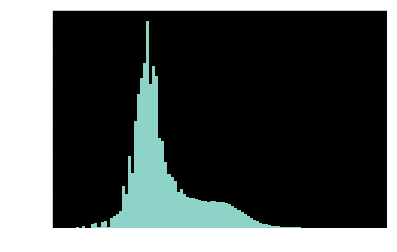

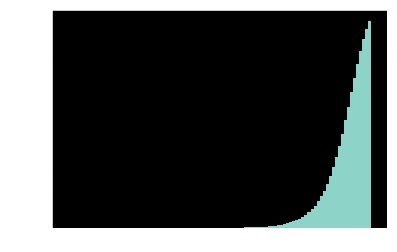

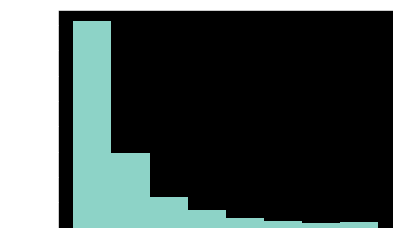

In [145]:
plt.hist(np.log10(spotcalls.ave),bins=100)
plt.show()
plt.hist(spotcalls.cword_dist,bins=100)
plt.show()
plt.hist(spotcalls.npixels,bins=np.arange(1,10))
plt.show()

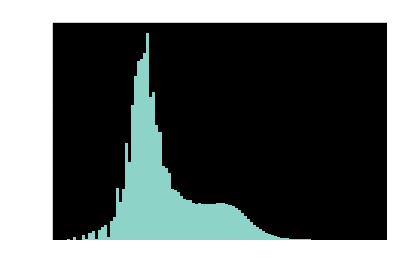

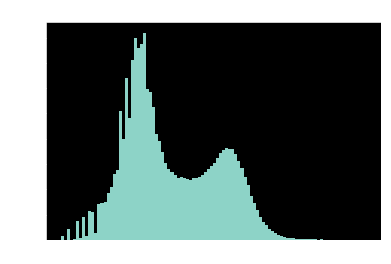

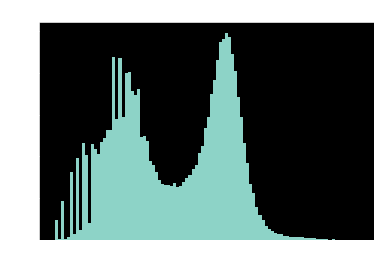

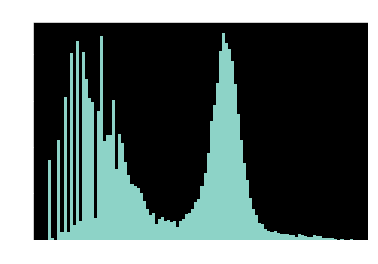

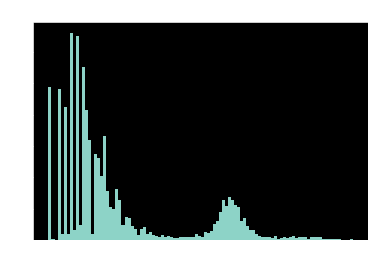

In [146]:
for i in [0.5,0.45,0.4,0.35,0.3]:
    plt.hist(np.log10(spotcalls[(spotcalls.cword_dist<i)].ave),bins=100)
    plt.title(i)
    plt.show()

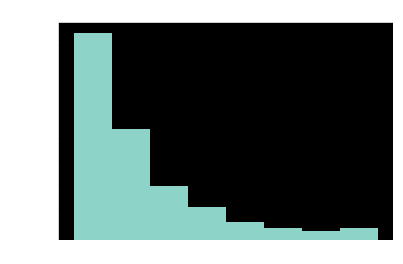

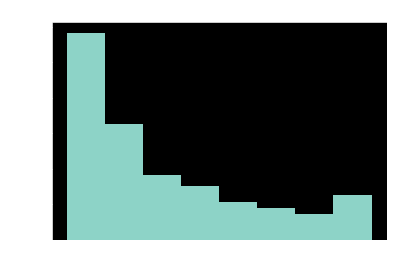

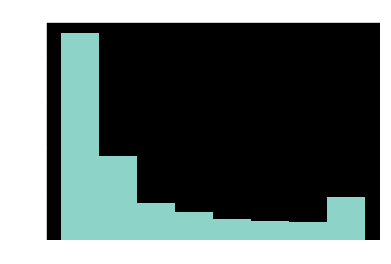

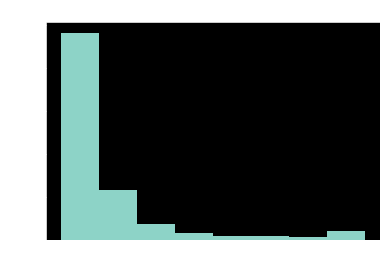

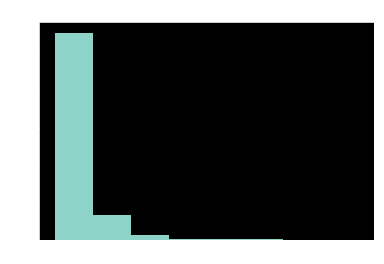

In [147]:
for i in [0.5,0.45,0.4,0.35,0.3]:
    plt.hist(spotcalls[(spotcalls.cword_dist<i)].npixels,bins=np.arange(1,10))
    plt.title(i)
    plt.show()

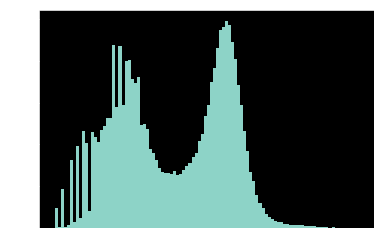

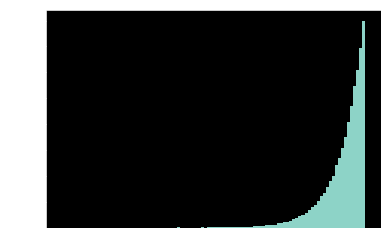

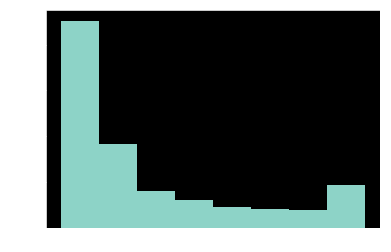

In [148]:
filtered_spotcalls = spotcalls[(spotcalls.cword_dist<0.4)]
plt.hist(np.log10(filtered_spotcalls.ave),bins=100)
plt.show()
plt.hist(filtered_spotcalls.cword_dist,bins=100)
plt.show()
plt.hist(filtered_spotcalls.npixels,bins=np.arange(1,10))
plt.show()

200628
7261420


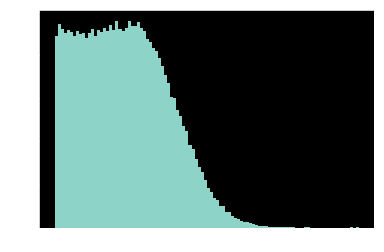

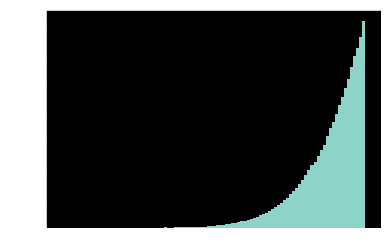

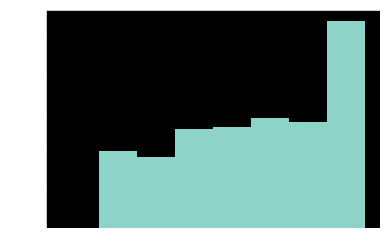

In [149]:
filtered_spotcalls = spotcalls[(spotcalls.ave>10**1.3)&(spotcalls.npixels>1)&(spotcalls.npixels<10)&(spotcalls.cword_dist<0.45)]
print(len(filtered_spotcalls))
print(len(spotcalls))
plt.hist(np.log10(filtered_spotcalls.ave),bins=100)
plt.show()
plt.hist(filtered_spotcalls.cword_dist,bins=100)
plt.show()
plt.hist(filtered_spotcalls.npixels,bins=np.arange(1,10))
plt.show()

158


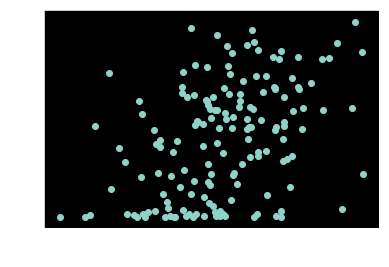

SpearmanrResult(correlation=0.4074452713643602, pvalue=1.0770289417565242e-07)

In [150]:
filtered_spotcalls = spotcalls[(spotcalls.ave>10**1.3)&(spotcalls.npixels>1)&(spotcalls.npixels<10)&(spotcalls.cword_dist<0.45)]
hip_fpkm.index = [i.capitalize() for i in hip_fpkm.index]
shared_genes = [i for i in filtered_spotcalls.gene.unique() if i in hip_fpkm.index]
shared_genes = [i for i in shared_genes if not 'Malat' in i]
print(len(shared_genes))
c = []
s = []
for gn,cc in Counter(filtered_spotcalls.gene).items():
    if gn in shared_genes:
        c.append(cc)
        ts = hip_fpkm['average'].loc[gn]
        if isinstance(ts,float):
            s.append(ts)
        else:
            s.append(ts.iloc[0])
plt.scatter(np.log10(np.array(c)+1),np.log10(np.array(s)+1))
plt.xlabel('sham_m3_slide4_2019Nov04 counts')
plt.ylabel('bulk hippocampus rnaseq')
plt.show()
spearmanr(c,s)

158


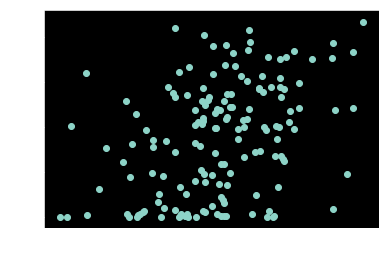

SpearmanrResult(correlation=0.38492052357440126, pvalue=5.922412583000399e-07)

In [151]:
filtered_spotcalls = spotcalls[(spotcalls.ave>10**1.3)&(spotcalls.npixels>1)&(spotcalls.npixels<10)]
hip_fpkm.index = [i.capitalize() for i in hip_fpkm.index]
shared_genes = [i for i in filtered_spotcalls.gene.unique() if i in hip_fpkm.index]
shared_genes = [i for i in shared_genes if not 'Malat' in i]
print(len(shared_genes))
c = []
s = []
for gn,cc in Counter(filtered_spotcalls.gene).items():
    if gn in shared_genes:
        c.append(cc)
        ts = hip_fpkm['average'].loc[gn]
        if isinstance(ts,float):
            s.append(ts)
        else:
            s.append(ts.iloc[0])
plt.scatter(np.log10(np.array(c)+1),np.log10(np.array(s)+1))
plt.xlabel('sham_m3_slide4_2019Nov04 counts')
plt.ylabel('bulk hippocampus rnaseq')
plt.show()
spearmanr(c,s)

Pos89
217937


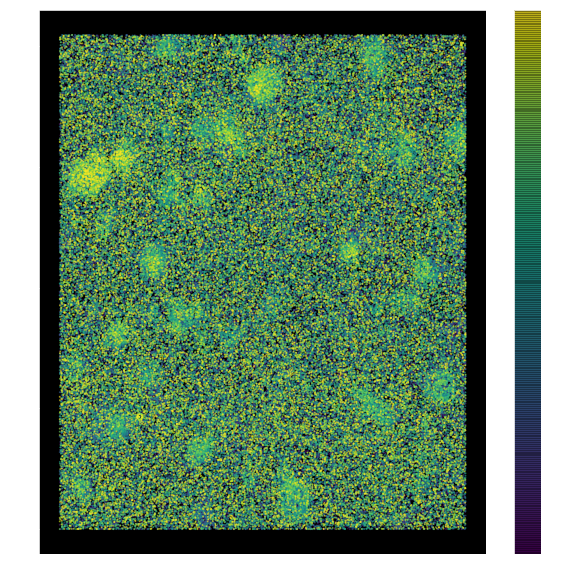

In [152]:
pos = spotcalls.posname.unique()[20]
print(pos)
pos_spotcalls = spotcalls[spotcalls.posname==pos]
print(len(pos_spotcalls))
plt.figure(figsize=[10,10])
plt.scatter(pos_spotcalls.x,pos_spotcalls.y,s=1,alpha=0.5,c=list(pos_spotcalls.z))
plt.colorbar()
plt.show()

Pos89
2608


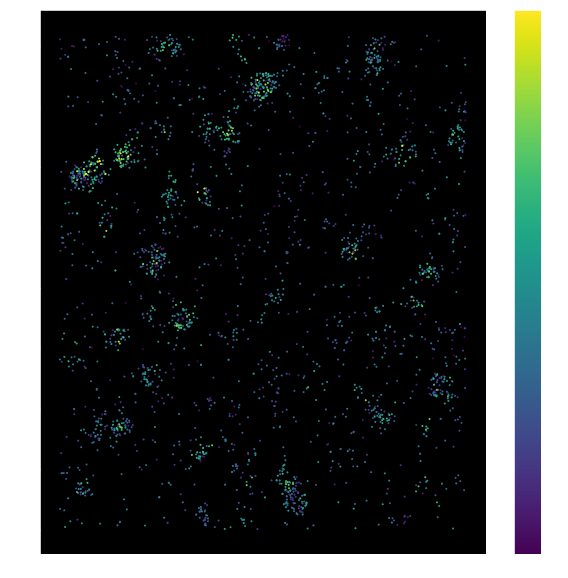

In [153]:
filtered_spotcalls = spotcalls[(spotcalls.ave>10**1.3)&(spotcalls.npixels>1)&(spotcalls.npixels<10)&(spotcalls.cword_dist<0.45)]
pos = filtered_spotcalls.posname.unique()[20]
print(pos)
pos_spotcalls = filtered_spotcalls[filtered_spotcalls.posname==pos]
print(len(pos_spotcalls))
plt.figure(figsize=[10,10])
plt.scatter(pos_spotcalls.x,pos_spotcalls.y,s=1,c=list(pos_spotcalls.z))
plt.colorbar()
plt.show()

Pos89
13577


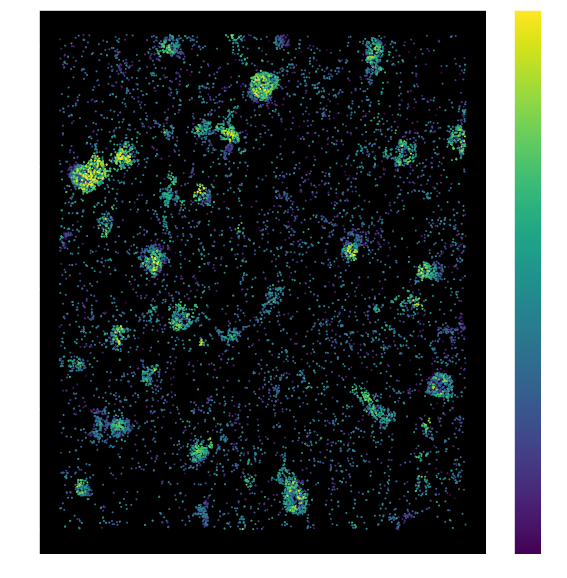

In [154]:
filtered_spotcalls = spotcalls[(spotcalls.ave>10**1.3)&(spotcalls.npixels>1)&(spotcalls.npixels<10)]
pos = filtered_spotcalls.posname.unique()[20]
print(pos)
pos_spotcalls = filtered_spotcalls[filtered_spotcalls.posname==pos]
print(len(pos_spotcalls))
plt.figure(figsize=[10,10])
plt.scatter(pos_spotcalls.x,pos_spotcalls.y,s=1,c=list(pos_spotcalls.z))
plt.colorbar()
plt.show()